In [20]:
# %matplotlib notebook
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
# import seaborn as sns


### To do:
- QC:
    * Delete ecol data pre 2000? Due to different counting method.
- Add wind. Will require JLG to download this data from e.g. the met station
- Source and add in mirocystin data?
- Add lake N species
- Add lake DIN:TP or TN:TP (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3996004/ for justification of which ratio to use)
- Better (more robust) lake TP flux estimate, e.g. monthly or seasonal fluxes. E.g. Beale or regression approach

In [21]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden). To do: perhaps combine the two datasets?
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0 # 0 or 1

# FILE PATHS to input data

# Met (T, pptn)
met_fpath = r'../data/Daily_1km_gridded_data_Morsa.csv'

# Discharge
Q_fpath = r'../data/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../data/003-59191_chem_obs.csv'

# Lake water quality
fname_dict = {'Van1':'Storefjorden (VAN1)', 'Van2':'Vanemfjorden (VAN2)'}
lakewq_fpath = r'../data/%s_chem_obs.csv'%fname_dict[basin]

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath = r'../data/%s_PTI_Cyano.xlsx'%basin

# Output files
out_file = r'../data/DataMatrices'

In [22]:
# READ IN
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)
catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)
lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin =='Van2':
    van1_fpath = r'../data/Storefjorden (VAN1)_chem_obs.csv'
    lakewq_df_van1 = pd.read_csv(van1_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)

### Some quality control

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bdad8ec50>,
      dtype=object)

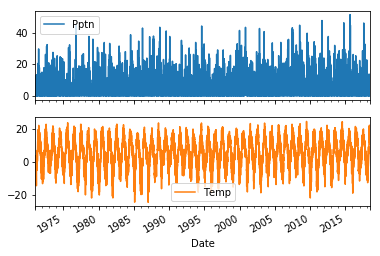

In [23]:
# For the met data, just pick the columns of interest and rename them
met_df = met_df[['RR','TG']]
met_df.columns = ['Pptn','Temp']
met_df.index.name = 'Date'
met_df.plot(subplots=True)

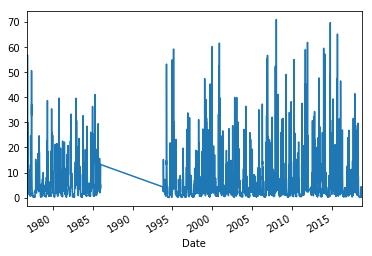

In [24]:
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)
Q_df.plot()

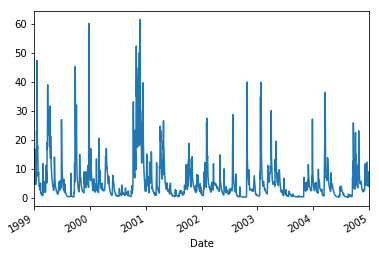

In [25]:
# Quick look at the autumn 2005 flood, thought to have caused the algal blooms in the period 2001-2007
Q_df.loc['1999-01-01':'2005-01-01'].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bdaddceb8>,
      dtype=object)

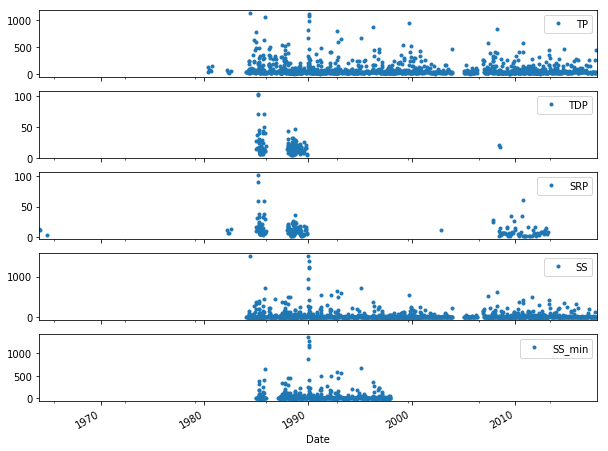

In [26]:
catchwq_df.plot(subplots=True, style='o', ms=3, figsize=(10,8))

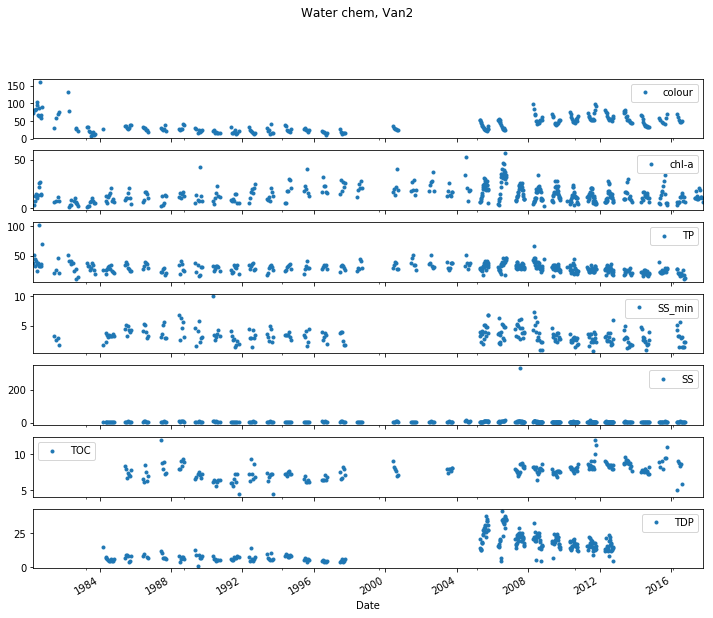

In [27]:
lakewq_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,10))
plt.suptitle('Water chem, %s' %basin)
# plt.savefig(r'../Figures/lake_chem_timeseries_%s.png' %basin)
plt.show()

**Seasonality:**
At Van2: TP over the summer generally roughly constant, sometimes increasing, sometimes increasing and then decreasing again.

At Van1: TP almost always starts high and then decreases over the summer

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bd960ecc0>,
      dtype=object)

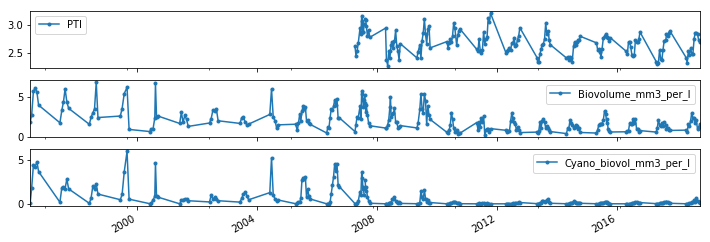

In [28]:
ecol_df.plot(subplots=True, style='o', ls='-', ms=3, figsize=(12,4))

**Comments:**

Van1 & Van2:
- Earliest lake data is in 1980, so drop all data from everything before then

- Dodgy data to be removed/not used:

    - Lake colour pre-August 1982
    - Lake dissolved P for Vansjø (TDP and SRP) show a big step-change between around 1998 and 2004. Not clear whether this is real, or either one side or the other of the step should be discarded. TP doesn't show this change. So for now only use TP and assume all dissolved P data (TDP, SRP) is dodgy
    - Mostly for plotting purposes, remove outliers from SS (and SS_min for Van1) (lake data): above 20 mg/l

- Precipitation data has one negative value; set to 0

Otherwise looks ok at first glance (aside from occasional outlier)

In [29]:
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN
met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

if basin == 'Van2':
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

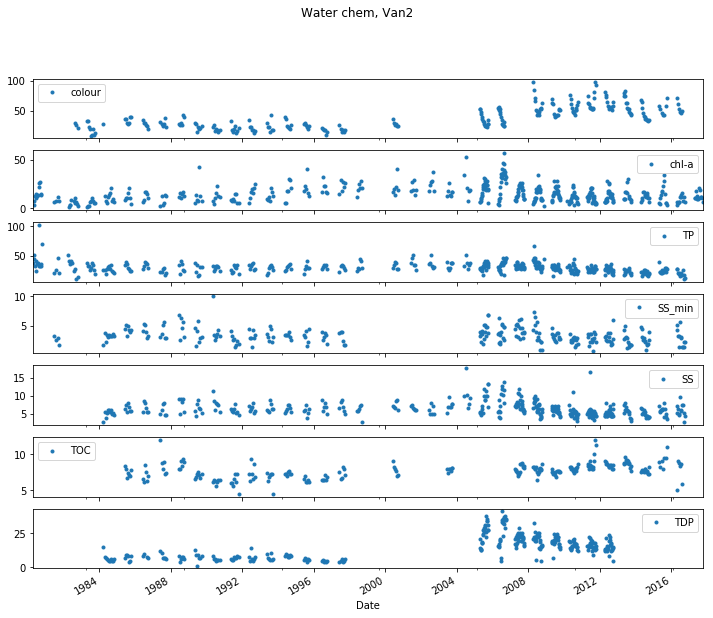

In [30]:
lakewq_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,10))
plt.suptitle('Water chem, %s' %basin)
# plt.savefig(r'../Figures/lake_chem_timeseries_%s.png' %basin)
plt.show()

### Useful functions and setup

### Combine data and add seasonal info

In [31]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2':
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

In [32]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2':
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

daily_df.columns.values

array(['Pptn', 'Temp', 'Q', 'TP_catch', 'TDP_catch', 'SRP_catch',
       'SS_catch', 'SS_min_catch', 'colour_lake', 'chl-a_lake', 'TP_lake',
       'SS_min_lake', 'SS_lake', 'TOC_lake', 'TDP_lake', 'PTI',
       'Biovolume_mm3_per_l', 'Cyano_biovol_mm3_per_l', 'colour_van1',
       'chl-a_van1', 'TP_van1', 'SS_min_van1', 'SS_van1', 'TOC_van1',
       'TDP_van1'], dtype=object)

In [33]:
# Drop some cols and rename others
# if basin == 'Van2':
#     cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
#                     'TOC_lake','TDP_lake','SS_lake','SS_min_lake',
#                     'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1']
# else:
#     cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
#                     'TOC_lake','TDP_lake','SS_lake','SS_min_lake']
    
if basin == 'Van2':
    cols_to_drop = ['SS_min_catch', 'TDP_catch','SRP_catch',
                    'TDP_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1']
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake']
    
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume','Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

print(daily_df.columns.values)

['Pptn' 'Temp' 'Q' 'TP_catch' 'SS_catch' 'colour_lake' 'chl-a_lake'
 'TP_lake' 'SS_lake' 'TOC_lake' 'PTI' 'Biovolume' 'CyanoBiovol'
 'colour_van1' 'chl-a_van1' 'TP_van1']


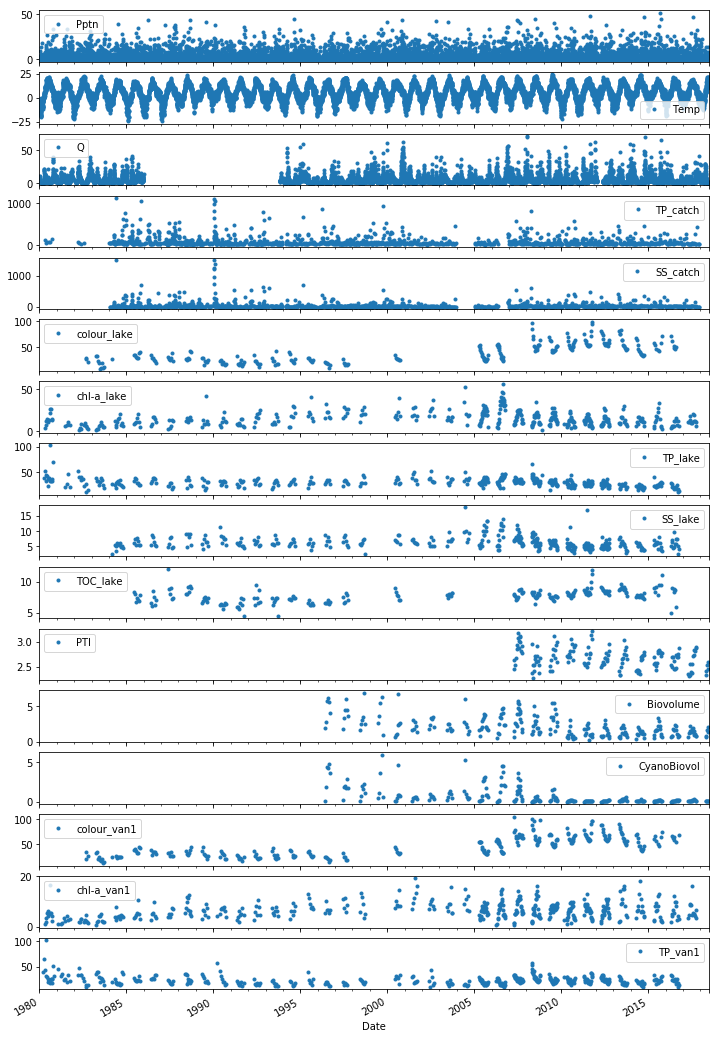

In [34]:
daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20));

In [14]:
# How many data points do we have, and how many are missing?

def missing_data(df):
    # Number of missing in each column
    missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'N_missing'})

    # Number of data points & percent missing
    missing['N_data'] = df.notna().sum()
    missing['percent_missing'] = missing['N_missing'] / len(df)

    missing = missing.sort_values('percent_missing', ascending = False)
    return(missing)

missing_data(daily_df)

,N_missing,N_data,percent_missing
PTI,13907,153,0.989118
CyanoBiovol,13828,232,0.983499
Biovolume,13827,233,0.983428
colour_lake,13819,241,0.982859
colour_van1,13799,261,0.981437
TP_lake,13633,427,0.969630
chl-a_lake,13622,438,0.968848
TP_van1,13621,439,0.968777
chl-a_van1,13615,445,0.968350
TP_catch,12678,1382,0.901707


In [15]:
# Add derived variables from daily data

# Proxy for lake residence time (assume volume is constant, and so
# residence time is proportional to 1/outflow, and that outflow is
# proportional to discharge at Kure)
daily_df['rel_res_time'] = 1/daily_df['Q']

if inc_fluxes == 1:

    # Daily TP flux (rough estimate only!)
    # First, rough interpolation of TP concentration from Kure to daily
    TP_interp = daily_df['TP_catch'].resample('D').interpolate(method='linear',limit=31)

    fig = plt.figure(figsize=(9,6))

    ax0 = fig.add_subplot(3,1,1)
    daily_df['Q'].plot(ax=ax0)
    plt.ylabel('Q (m3/s)')

    ax1 = fig.add_subplot(3,1,2)
    TP_interp.plot(ax=ax1)
    plt.ylabel('Kure [TP] interp (ug/l)')
    daily_df['TP_catch'].plot(ax=ax1, style='r.')
    # Calc flux (kg/day)
    daily_df['TP_flux'] = daily_df['Q']*TP_interp*86400*(10**-6)

    ax2 = fig.add_subplot(3,1,3)
    daily_df['TP_flux'].plot(ax=ax2)
    plt.ylabel('Kure TP flux (kg/d)')
    
    daily_df['TP_flux'].describe()

In [16]:
# Precipitation features:
# (1) rain day (boolean of whether it rained that day or not)
def rain_day(pptn):
    if pptn>0.: return 1
    else: return 0
daily_df['Rain_day'] = daily_df['Pptn'].map(rain_day)
print (daily_df[['Pptn','Rain_day']].head())

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.693679         1
1980-01-05  3.016553         1


8.46460157957698
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.693679             0
1980-01-05  3.016553             0


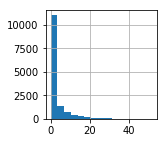

In [17]:
# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df['Pptn'].hist(bins=15, figsize=(2,2))
print (daily_df['Pptn'].quantile(q=0.90))

# Therefore decide to use threshold of 90th percentile, 8.2 mm/day
def rain_intense(pptn):
    if pptn>8.2: return 1
    else: return 0
daily_df['Pptn_intense'] = daily_df['Pptn'].map(rain_intense)
print (daily_df[['Pptn','Pptn_intense']].head())

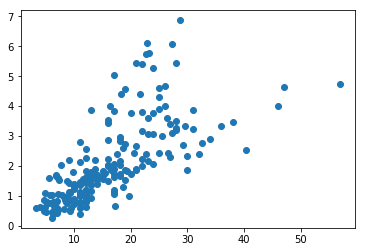

In [18]:
# Plot one variable against another

# plt.plot(np.log(daily_df['Q']), np.log(daily_df['TP_catch']),'o')
plt.plot(daily_df['chl-a_lake'], daily_df['Biovolume'],'o')

In [19]:
# pd.plotting.scatter_matrix(daily_df, figsize=(12,12))
# plt.show()

In [20]:
# Optionally output to csv
# daily_df.to_csv(os.path.join(out_file,'Vansjø_daily_data_%s.csv' %basin), index_label='Date')

## Resample

In [21]:
daily_df.columns

Index(['Pptn', 'Temp', 'Q', 'TP_catch', 'colour_lake', 'chl-a_lake', 'TP_lake',
       'PTI', 'Biovolume', 'CyanoBiovol', 'colour_van1', 'chl-a_van1',
       'TP_van1', 'rel_res_time', 'Rain_day', 'Pptn_intense'],
      dtype='object')

In [22]:
# Set the aggregation method for different variables
vars_to_sum = ['Pptn','TP_flux','Rain_day','Pptn_intense']
if inc_fluxes == 0:
    vars_to_sum.remove('TP_flux')
vars_to_average = ['TP_catch',
                 'CyanoBiovol',
                 'PTI',
                 'Temp',
                 'Q',
                 'Biovolume',
                 'rel_res_time',
                 'colour_lake',
                 'TP_lake',
                 'chl-a_lake']

if basin == 'Van2':
    vars_to_average.extend(['colour_van1','TP_van1','chl-a_van1'])

agg_method_dict = {} # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    else:
        method = None
    agg_method_dict[var] = method

### Resample to monthly

Poss response variables:
- TP_lake: mean lake TP concentration (ug/l)
- chl-a_lake: mean lake chl-a concentration (ug/l)
- CyanoBiovol: mean biovolume of cyanobacteria (mm3/l)
- Biovolume: mean total biovolume (mm3/l)
- 'Status_%s' %var. WFD class boundaries for vars TP_lake, chl-a_lake and CyanoBiovol, split into 3 classes: HG - high/good, M - moderate, PB - poor/bad
  
Other poss response variables that I haven't made matrices for yet:
- PTI: mean phytoplankton trophic index
- lake colour (if e.g. it turns out to be an important predictor for cyanobacteria)

Description of columns (this is all the possible explanatory variables; the exact selection will vary depending on the explanatory variable):

- colour_lake: mean lake colour (mg/l Pt (whatever pt means...?))
- Month: month of year, 1-12
- Pptn: monthly precipitation (mm/month)
- Pptn_intense: Number of days when rainfall was intense in the month (>90th percentile, 8.2mm/day)
- Q: Monthly mean of daily mean discharge at Kure (m3/s)
- Rain_day: Number of days of rain in the month
- Season: split into 4, wint: JFM, spr: AMJ, summ: JAS, aut: OND
- Season_2: boolean, split into 2: 0 for Nov-March (winter), 1 for Apr-Oct (summer)
- suffix _lag1M: value from the previous month
- suffix _lagxM_av, where x is between 2 and 3: Mean of values from previous x months (excluding current month)
- suffix _lagxM_sum, where x is between 2 and 6: Sum of values from previous x months (excluding current month)
- suffix '_prevSummer': mean of variable during the summer of the previous year (jun-aug), or WFD status calculated from mean of associated variables (starting with daily data)
- suffix '_winterSum': sum of values for previous winter (Oct-March incl.)
- Temp: Air temperature
- TP_catch: mean concentration of TP in the Hobølelva at Kure (ug/l)
- TP_flux: estimate of monthly TP flux in Hobølelva at Kure (kg/month). This inputs to Van1.
- TP_lake: mean lake TP concentration (ug/l)

If looking at van2 (Vanemfjorden), then inputs from the eastern basin (Storefjorden, van1), are also included as possible explanatory variables:
- TP_van1: Lake TP concentration at Van1 (ug/l). Associated lags too.
- chl-a_van1: Lake chl-a conc at Van1 (ug/l)
- colour_van1: Lake colour at Van1

In [23]:
monthly_df = daily_df.resample('M').agg(agg_method_dict)

# This gives 0s for TP_flux sums where everything in the month was NaNs. Should be NaN.
# This is a bug, but for now correct for it re-setting as NaN
if inc_fluxes == 1:
    monthly_df.loc[monthly_df['TP_catch'].isnull(),'TP_flux'] = np.nan
    monthly_df.loc[monthly_df['Q'].isnull(),'TP_flux'] = np.nan

monthly_df.head()

,Pptn,Temp,Q,TP_catch,colour_lake,chl-a_lake,TP_lake,PTI,Biovolume,CyanoBiovol,colour_van1,chl-a_van1,TP_van1,rel_res_time,Rain_day,Pptn_intense
Date,,,,,,,,,,,,,,,,
1980-01-31,22.434315,-8.091381,4.149765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345080,19,1
1980-02-29,33.537067,-9.190934,0.345600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.009479,17,1
1980-03-31,36.902469,-4.001408,0.365793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.500000,2.937803,18,1
1980-04-30,10.553205,4.218885,10.717172,130.0,NaN,3.971429,45.250000,NaN,NaN,NaN,NaN,1.233333,53.559028,0.168976,10,0
1980-05-31,59.362142,11.237943,4.432067,50.0,NaN,9.948810,38.857143,NaN,NaN,NaN,NaN,2.680000,67.075000,0.287349,12,4


In [24]:
# WFD class boundaries
# Units for TP and chl-a: ug/L. For cyanobacterial biovolume: mm3/L (=ug/l values /1000)
WFD_class_dict = {'TP_lake': {'G-M':20., 'M-P':39.},
                  'chl-a_lake': {'G-M':10.5, 'M-P':20.},
                  'CyanoBiovol': {'G-M':1., 'M-P':2.}
                 }

def classify_WFD(var,val):
    if np.isnan(val):
        return np.NaN
    elif val<WFD_class_dict[var]['G-M']:
        return 'HG'
    elif val<WFD_class_dict[var]['M-P']:
        return 'M'
    else:
        return 'PB'

for var in WFD_class_dict.keys():
    monthly_df['status_%s'%var] = monthly_df[var].apply(lambda x: classify_WFD(var, x))

In [25]:
# list(monthly_df.columns)

#### Add lagged variables  and month

In [26]:
# For all variables, add 1 month lag
for var in monthly_df.columns:
    monthly_df['%s_lag1M' %var] = monthly_df[var].shift(+1)

# Add a column for the month
monthly_df['Month'] = monthly_df.index.month
    
monthly_df[['chl-a_lake','TP_catch','TP_catch_lag1M']].head()

,chl-a_lake,TP_catch,TP_catch_lag1M
Date,,,
1980-01-31,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN
1980-04-30,3.971429,130.0,NaN
1980-05-31,9.948810,50.0,130.0


In [27]:
# For all variables that are summed on aggregating, calculate the sum for the
# previous winter (October - March)

# First, add a 'season_2' column, splitting data into 'winter' (Oct-March) and 'summer' (Apr-Sep)
# N.B. October lake sampling in 'winter' then
def growing_season(month):
    if month<4 or month>9:
        return 0
    else:
        return 1
monthly_df['season_2'] = monthly_df.index.month.map(growing_season)

# Then filter to just winter and calculate winter sums per year
wint_sum_df = monthly_df.loc[monthly_df['season_2']==0, vars_to_sum]

# Need to take account of fact that one season spans two years
wint_sum_df = wint_sum_df.iloc[3:] # Drop first 3 values, as only half a season
# Make series of years to sum over (e.g. Oct-Mar of yr-1 to yr)
yr_li = []
for yr in range(1981,2019):
    a = 6*[yr]
    yr_li.extend(a)
wint_sum_df['sum_yr'] = yr_li

if inc_fluxes == 1:
    # Do some patching: forward & backward fill up to one month of NaNs in TPflux
    wint_sum_df['TP_flux'].fillna(method='ffill',limit=1, inplace=True)
    wint_sum_df['TP_flux'].fillna(method='bfill',limit=1, inplace=True)

# Group by years and work out number of months with obs (for filtering
# out years where don't have enough months with obs). And sum!
wint_sum_df_counts = wint_sum_df.groupby('sum_yr').count()
wint_sum_df = wint_sum_df.groupby('sum_yr').sum()
if inc_fluxes == 1:
    # Filter out values with 1-3 months of observations
    wint_sum_df.loc[wint_sum_df_counts['TP_flux']<4,'TP_flux'] = np.NaN

# Add 1980, though it's NaN, for compatibility with monthly df
wint_sum_df.loc[1980] = len(wint_sum_df.columns)*[np.NaN]
wint_sum_df.sort_index(inplace=True)
# print (wint_sum_df.head())

for var in vars_to_sum:
    monthly_df['%s_winterSum' %var] = monthly_df[var].index.year.map(lambda x: wint_sum_df.loc[x,var])

# print monthly_df.loc['1981':'1982',['Rain_day','Rain_day_winterSum']]

In [28]:
# Next, means or sums of previous 2-3 months of except the lake vars.
# For the lake variables, the seasonal sampling (only April or May to Sep or Oct) means this
# lagging introduces too many missing values for the analysis

for var in vars_to_sum:
    for months in [2,3,4,5,6]:
        # First, shift one place so is lagged, then aggregate
        lagged_col = monthly_df[var].shift(+1)
        roll_sum = lagged_col.rolling(months, min_periods=months, closed='right').sum()
        monthly_df['%s_lag%sM_sum'%(var,months)] = roll_sum

# Replave vars_to_average with just non-lake vars, i.e.
for var in ['TP_catch','Temp','Q','rel_res_time']:
    for months in [2,3]:
        # First, shift one place so is lagged, then aggregate
        lagged_col = monthly_df[var].shift(+1)
        roll_mean = lagged_col.rolling(months, min_periods=months, closed='right').mean()
        monthly_df['%s_lag%sM_av'%(var,months)] = roll_mean

monthly_df[['Rain_day','Rain_day_lag2M_sum','Rain_day_lag3M_sum','TP_catch']].head()
# monthly_df[['TP_lake','TP_lake_lag2M_av','TP_lake_lag3M_av']].head(10)

,Rain_day,Rain_day_lag2M_sum,Rain_day_lag3M_sum,TP_catch
Date,,,,
1980-01-31,19,NaN,NaN,NaN
1980-02-29,17,NaN,NaN,NaN
1980-03-31,18,36.0,NaN,NaN
1980-04-30,10,35.0,54.0,130.0
1980-05-31,12,28.0,45.0,50.0


In [29]:
# Add mean for previous summer for in-lake ecol variables

prev_summ_vars = ['chl-a_lake', 'TP_lake', 'CyanoBiovol',
                 'status_chl-a_lake','status_TP_lake','status_CyanoBiovol']

if basin =='Van2':
    prev_summ_vars.extend(['chl-a_van1', 'TP_van1'])

# First, RESAMPLE TO SEASONAL

# Define 4 seasons per year. Lake sampling is from mid-April to mid-October.
# Value is returned for the last day of the season

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [12,1,2]:
        return 'wint'
    if x in [3,4,5]:
        return 'spr'
    if x in [6,7,8]:
        return 'summ'
    if x in [9,10,11]:
        return 'aut'

monthly_df['Season'] = monthly_df.index.month.map(season)

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample('Q-Feb').agg(agg_method_dict)
season_df['Season'] = season_df.index.month.map(season)

# Calculate WFD status for the season
for var in ['TP_lake','chl-a_lake', 'CyanoBiovol']:
    season_df['status_%s'%var] = season_df[var].apply(lambda x: classify_WFD(var, x))

# print (season_df.head(4))

# Map season from previous year to values in current year for summer months
summer_df = season_df.loc[season_df['Season']=='summ',prev_summ_vars]
summer_df['Year+1'] = summer_df.index.year + 1
# print (summer_df.head())

for var in prev_summ_vars:
    for idx in monthly_df.index:
        # First year with data is 1980, so no values for previous year. In this case, add NaNs
        if idx.year < 1981:
            prev_summer_val = np.nan
        else:
            prev_summer_val = summer_df[var].loc[summer_df['Year+1']==idx.year].values

        
        monthly_df.loc[idx, '%s_prevSummer'%var] = prev_summer_val
        
        
monthly_df[['TP_lake','TP_lake_prevSummer','status_TP_lake','status_TP_lake_prevSummer']].head(13)

,TP_lake,TP_lake_prevSummer,status_TP_lake,status_TP_lake_prevSummer
Date,,,,
1980-01-31,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN
1980-04-30,45.250000,NaN,PB,NaN
1980-05-31,38.857143,NaN,M,NaN
1980-06-30,32.633333,NaN,M,NaN
1980-07-31,36.761905,NaN,M,NaN
1980-08-31,67.400000,NaN,PB,NaN
1980-09-30,33.857143,NaN,M,NaN


In [30]:
# print (len(monthly_df.columns))
# sorted(monthly_df.columns)

## Split into separate matrices for the 3 possible response variables

### 1) Explanatory var = lake TP concentration

In [31]:
sorted(monthly_df.columns)

['Biovolume',
 'Biovolume_lag1M',
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
 'CyanoBiovol_prevSummer',
 'Month',
 'PTI',
 'PTI_lag1M',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1M',
 'Pptn_intense_lag2M_sum',
 'Pptn_intense_lag3M_sum',
 'Pptn_intense_lag4M_sum',
 'Pptn_intense_lag5M_sum',
 'Pptn_intense_lag6M_sum',
 'Pptn_intense_winterSum',
 'Pptn_lag1M',
 'Pptn_lag2M_sum',
 'Pptn_lag3M_sum',
 'Pptn_lag4M_sum',
 'Pptn_lag5M_sum',
 'Pptn_lag6M_sum',
 'Pptn_winterSum',
 'Q',
 'Q_lag1M',
 'Q_lag2M_av',
 'Q_lag3M_av',
 'Rain_day',
 'Rain_day_lag1M',
 'Rain_day_lag2M_sum',
 'Rain_day_lag3M_sum',
 'Rain_day_lag4M_sum',
 'Rain_day_lag5M_sum',
 'Rain_day_lag6M_sum',
 'Rain_day_winterSum',
 'Season',
 'TP_catch',
 'TP_catch_lag1M',
 'TP_catch_lag2M_av',
 'TP_catch_lag3M_av',
 'TP_lake',
 'TP_lake_lag1M',
 'TP_lake_prevSummer',
 'TP_van1',
 'TP_van1_lag1M',
 'TP_van1_prevSummer',
 'Temp',
 'Temp_lag1M',
 'Temp_lag2M_av',
 'Temp_lag3M_av',
 'chl-a_lake',
 'chl-a_lake_lag1M',
 'chl-a_lake_prevSumme

In [32]:
# First, lake TP concentration is the explanatory variable.
# So drop all ecological-related stuff. Biol could use up P, and therefore have
# a negative relationship with TP. But correlations are all positive (i.e.
# relationship seems to be mostly the other way around), so remove for
# simplicity. Also drop relative residence time, as it's a function of Q, and
# not looking particularly important compared to Q

cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'chl-a_lake',
 'chl-a_lake_lag1M',
#  'chl-a_lake_lag2M_av',
#  'chl-a_lake_lag3M_av',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_lag1M',
#  'colour_lake_lag2M_av',
#  'colour_lake_lag3M_av', 
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
#  'CyanoBiovol_lag2M_av',
#  'CyanoBiovol_lag3M_av',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer']
#  'rel_res_time',
#  'rel_res_time_lag1M',
#  'rel_res_time_lag2M_av',
#  'rel_res_time_lag3M_av',

if basin == 'Van2':
    extra_cols_to_drop = [
    'chl-a_van1',
    'chl-a_van1_lag1M',
#     'chl-a_van1_lag2M_av',
#     'chl-a_van1_lag3M_av',
    'chl-a_van1_prevSummer',
    'colour_van1',
    'colour_van1_lag1M',
#     'colour_van1_lag2M_av',
#     'colour_van1_lag3M_av'
    ]
    cols_to_drop = cols_to_drop+extra_cols_to_drop

monthly_df_lakeTP = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_lakeTP))

# Drop any rows where TP_lake is a NaN
monthly_df_lakeTP.dropna(subset=['TP_lake'], inplace=True)
print (len(monthly_df_lakeTP))
monthly_df_lakeTP.head()

462
198


,Pptn,Temp,Q,TP_catch,TP_lake,TP_van1,rel_res_time,Rain_day,Pptn_intense,Pptn_lag1M,...,TP_catch_lag3M_av,Temp_lag2M_av,Temp_lag3M_av,Q_lag2M_av,Q_lag3M_av,rel_res_time_lag2M_av,rel_res_time_lag3M_av,Season,TP_lake_prevSummer,TP_van1_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,10.553205,4.218885,10.717172,130.0,45.250000,53.559028,0.168976,10,0,36.902469,...,NaN,-6.596171,-7.094574,0.355697,1.620386,2.973641,2.097454,spr,NaN,NaN
1980-05-31,59.362142,11.237943,4.432067,50.0,38.857143,67.075000,0.287349,12,4,10.553205,...,NaN,0.108739,-2.991152,5.541483,3.809522,1.553389,2.038752,spr,NaN,NaN
1980-06-30,131.738069,15.539921,4.893233,80.0,32.633333,24.444444,0.264810,25,6,59.362142,...,NaN,7.728414,3.818473,7.574620,5.171677,0.228162,1.131376,summ,NaN,NaN
1980-07-31,51.099007,16.605522,3.487091,75.0,36.761905,22.888889,0.435075,26,1,131.738069,...,86.666667,13.388932,10.332250,4.662650,6.680824,0.276079,0.240378,summ,NaN,NaN
1980-08-31,96.991814,14.394161,1.856323,70.0,67.400000,20.345238,0.785827,24,5,51.099007,...,68.333333,16.072722,14.461129,4.190162,4.270797,0.349942,0.329078,summ,NaN,NaN


In [33]:
missing_data(monthly_df_lakeTP).head(15)

,N_missing,N_data,percent_missing
rel_res_time_lag3M_av,47,151,0.237374
Q_lag3M_av,47,151,0.237374
Q_lag2M_av,44,154,0.222222
rel_res_time_lag2M_av,44,154,0.222222
rel_res_time_lag1M,41,157,0.207071
Q_lag1M,41,157,0.207071
Q,40,158,0.202020
rel_res_time,40,158,0.202020
TP_van1_lag1M,39,159,0.196970
TP_lake_lag1M,39,159,0.196970


In [34]:
# Take a look at what's missing
# First, drop any columns which don't have NaNs, then plot
# monthly_df_lakeTP.loc[:, monthly_df_lakeTP.isna().any()].plot(subplots=True, figsize=(12,30))

In [35]:
X = monthly_df_lakeTP.drop(['TP_lake'],axis=1)
y = monthly_df_lakeTP['TP_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Pptn_intense_lag1M       -0.159657
Month                    -0.121309
Pptn_intense_lag2M_sum   -0.118566
Pptn_intense_lag3M_sum   -0.108549
Temp_lag3M_av            -0.095716
rel_res_time_lag3M_av    -0.093343
Rain_day                 -0.087353
Pptn_lag1M               -0.085962
Temp_lag2M_av            -0.083352
Pptn_intense_lag4M_sum   -0.082074
rel_res_time_lag2M_av    -0.064156
Temp_lag1M               -0.062731
Pptn_lag2M_sum           -0.061076
Pptn_lag3M_sum           -0.059430
Rain_day_lag3M_sum       -0.052540
Pptn_lag4M_sum           -0.045355
rel_res_time_lag1M       -0.042677
Rain_day_lag2M_sum       -0.041144
Rain_day_lag4M_sum       -0.040280
Rain_day_lag5M_sum       -0.032639
TP_catch                 -0.025612
Pptn_lag6M_sum           -0.025275
Pptn_intense_lag5M_sum   -0.024342
Pptn_lag5M_sum           -0.021839
Q_lag1M                  -0.020548
Pptn_intense_lag6M_sum   -0.018951
Rain_day_lag6M_sum       -0.018061
Rain_day_lag1M           -0.016078
Pptn_intense        

In [36]:
monthly_df_lakeTP.to_csv(os.path.join(out_file,'dataMatrix_monthly_TP_%s.csv'%basin), index_label='Date')

**Comments:**

Van 2 (Vanemfjorden):
- by far the best explanatory variables are lake TP concentration from the previous 1-3 months, then the previous summer (correlation coefficients 0.3 to 0.6).
- TP concentration in Storefjorden (Van1) potentially exerts some influence (0.3)
- Everything else much weaker (ccs less than 0.16).
- **No link to air T seen, unlike Storefjorden**. Because it's shallower?
- No relation with met variables relating to delivery. Suggesting internal processing and P sources are more important?

Van 1 (Storefjorden):
- Strong negative correlation with air temperature the previous month (up to -0.6) & lags, month
- Strong positive correlation with lake TP previous month (0.6), and lags
- Weaker but still pretty ok +ve correlations (around 0.35-0.45): Q & Q-1M, rain days over past 5-6 months, TP fluxes (4-6M), Pptn sum (6M)
- (though small -ve correlations with e.g. rain days, intense pptn days and pptn in the current month...)
- Lake colour positively correlated to lake TP (cc ~0.5)

i.e. Storefjorden shows much stronger relationship to weather variables. Why such a strong negative relationship with air temperature?! Warmer = lower lake TP. Due to biol using it up? But correlation with chl-a is weaker (-0.3), biovol weaker still (-0.2). Most likely due to **stratification**? Warmer=stable, stratified waters that are depleted in P, versus mixing and more P-rich waters in winter??

Unlike Vanemfjorden, Storefjorden TP conc also potentially influenced by catchment inputs over last few months. Suggests perhaps that delivery is more important than internal processing here, whilst internal fluxes swamp delivery signal in Vanemfjorden? 

### 2) Explanatory var = Lake chl-a concentration

In [37]:
# 2) chl-a concentration
# cols to drop:
cols_to_drop = ['Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
#  'CyanoBiovol_lag2M_av',
#  'CyanoBiovol_lag3M_av',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'rel_res_time',
 'rel_res_time_lag1M',
 'rel_res_time_lag2M_av',
 'rel_res_time_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer'
               ]

monthly_df_lake_chla = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
monthly_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print (len(monthly_df_lake_chla))
# monthly_df_lake_chla.head()

462
202


In [38]:
X = monthly_df_lake_chla.drop(['chl-a_lake'],axis=1)
y = monthly_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Q_lag1M                  -0.386850
TP_van1                  -0.357043
Q                        -0.356612
Q_lag2M_av               -0.298473
colour_lake              -0.287084
TP_van1_lag1M            -0.239931
colour_van1              -0.227215
Q_lag3M_av               -0.210400
TP_van1_prevSummer       -0.205794
TP_catch_lag1M           -0.194092
colour_lake_lag1M        -0.180196
Pptn_lag6M_sum           -0.179429
Pptn_lag5M_sum           -0.151729
TP_catch_lag2M_av        -0.148091
TP_catch                 -0.128773
TP_catch_lag3M_av        -0.117190
Pptn_lag4M_sum           -0.101972
colour_van1_lag1M        -0.101624
Pptn_intense_lag6M_sum   -0.073495
Pptn_intense_lag5M_sum   -0.039070
Rain_day_lag4M_sum       -0.012604
Rain_day_lag3M_sum       -0.007162
Pptn_lag3M_sum           -0.006904
Pptn_intense_winterSum   -0.003337
Pptn_winterSum            0.015883
Pptn_intense_lag4M_sum    0.020267
Rain_day_lag5M_sum        0.025121
Pptn_intense              0.039498
Rain_day_lag2M_sum  

**Comments:**
Van2:
* Most important variables are chl-a concentration in van1 (cc 0.63), chl-a concentration in lake in the previous month, followed closely by temperature, and then related variables lagged temp and chl-a, including chl-a from previous summer. Lake TP concentration in current month after that, then various lagged versions of it.
* Negative relationship with Q (and therefore TP flux)! Because Q flushes chl-a away? Bigger CC than Lake TP concentration CC. i.e. important. Also negative with TP conc in van1, but probably because both chl-a and TP_van1 are controlled by temperature
* Negative CC with colour. However, colour probably positively correlated to Q, so may just be that

i.e. key factors look likely to be chl-a_van1, chl-a_lake_lag1M, Temp (and related lags), Q_lag1M, chl-a_lake_prevSummer, TP_lake. Likely that chl-a_van1 actually exerts a control on chl-a in van2? Or just that they respond similarly to the same drivers?

Van1:
* Positive: most important are temp (and then lags), chl-a_lag1M. Perhaps colour too (lagged)
* Negative: weaker but probably significant correlations with Q, TP_lake and TP_flux in current month (around -0.3). Negative relation with TP_lake!!! But because of strong positive relationship between chl-a and temperature, and strong negative relationship between TP_lake and temp (see above), rather than because the two are linked. i.e. have stratified warm, low-TP summer waters with high chl-a.

i.e. similar drivers to van2.

In [39]:
monthly_df_lake_chla.to_csv(os.path.join(out_file,'dataMatrix_monthly_Chl-a_%s.csv'%basin), index_label='Date')

### 3) Explanatory var = cyanobacterial biovolume

In [40]:
# cols to drop:
cols_to_drop = ['Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'rel_res_time',
 'rel_res_time_lag1M',
 'rel_res_time_lag2M_av',
 'rel_res_time_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer'
               ]

monthly_df_cyano = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_cyano))

# Drop any rows where explanatory var value is a NaN
monthly_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print (len(monthly_df_cyano))
# monthly_df_lake_chla.head()

462
125


In [41]:
X = monthly_df_cyano.drop(['CyanoBiovol'],axis=1)
y = monthly_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y)
corr_df.sort_values()

colour_lake_lag1M        -0.677491
colour_lake              -0.667968
colour_van1              -0.633166
colour_van1_lag1M        -0.629307
TP_van1                  -0.406118
Q_lag2M_av               -0.342923
Q_lag1M                  -0.332551
TP_van1_lag1M            -0.302799
Q_lag3M_av               -0.274636
Q                        -0.230677
Pptn_lag6M_sum           -0.218959
Pptn_lag5M_sum           -0.165089
Pptn_winterSum           -0.160400
Rain_day_lag5M_sum       -0.146868
Pptn_intense_winterSum   -0.146219
Rain_day_lag6M_sum       -0.143355
Pptn_intense_lag6M_sum   -0.129701
Rain_day_lag4M_sum       -0.128236
TP_catch_lag1M           -0.127204
TP_catch_lag2M_av        -0.126548
Rain_day_lag3M_sum       -0.123345
Rain_day_lag2M_sum       -0.121807
Pptn_lag4M_sum           -0.106235
TP_van1_prevSummer       -0.100571
Rain_day_lag1M           -0.084755
Pptn_intense_lag5M_sum   -0.074461
chl-a_van1_prevSummer    -0.063474
Pptn_lag2M_sum           -0.045619
TP_catch_lag3M_av   

**Comments:**

VAN2:
- Strong positive correlations with cyanobiovol value previous 1-3 months, current chl-a, and cyanobiovol from previous summer.
- Strong negative correlation with lake colour from current and previous 1-3 months, for van2 and van1. i.e. higher colour means lower cyanobacteria (light limitation?). Why isn't this effect seen for chl-a?

VAN1:
- Similar to Van2 in terms of positive corrlelations
- Unlike Van2, no strong negative correlation with lake colour. Strongest -ve is with TP_lake (but see comments about chl-a above)
- i.e. key predictors are probably chl-a and cyanobiovol from previous month

Why the strong correlation with colour in van2, but not in van1? Because van1 has a much smaller gradient in cyanobiovol, so don't reach light limitation because other things are limiting?

In [42]:
monthly_df_cyano.to_csv(os.path.join(out_file,'dataMatrix_monthly_CyanoBiovol_%s.csv'%basin), index_label='Date')

### How balanced are the classes?

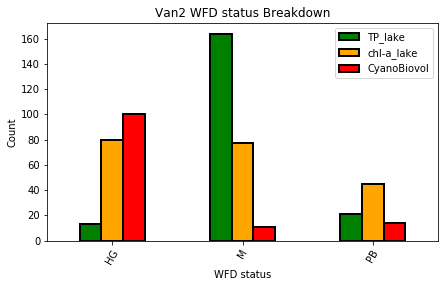

In [43]:
# How unbalanced are the classes? Very!

from collections import OrderedDict

# Color mapping
colors = OrderedDict({1: 'green', 2: 'orange', 3: 'red'})
status_mapping = OrderedDict({1: 'HG', 2: 'M', 3: 'PB'})

# Value counts of target
label_counts = pd.DataFrame()
for var in WFD_class_dict.keys():
    label_counts['%s'%var] = monthly_df['status_%s'%var].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (7, 4), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('WFD status'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in status_mapping.keys()], 
           list(status_mapping.values()), rotation = 60)
plt.title('%s WFD status Breakdown'%basin);

Van1: Very unbalanced. Almost no PB obs for any variables:
- TP split between HG and M (M about 25% higher than HG), tiny bit in PB
- Cyano all HG
- Chl-a mostly HG, little bit in M

Van2: Unbalanced for TP and cyano, chl-a is pretty balanced:
- Almost all TP is M, small HG & PB
- Most cyano is HG, but some M and PB
- chl-a fairly balanced (PB slightly smaller than others)

In [44]:
# Output to csv
monthly_df.to_csv(os.path.join(out_file,'Vansjø_monthly_data_%s.csv' %basin), index_label='Date')

In [45]:
monthly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pptn,462.0,76.661995,45.278076,0.672300,43.657425,69.495204,103.358857,299.049098
Temp,462.0,5.726480,7.502281,-12.411057,-0.234401,5.286621,12.211478,19.930341
Q,364.0,5.124776,4.518371,0.082500,1.690943,3.977243,7.125119,34.031467
TP_catch,391.0,81.162981,71.385602,18.000000,38.600000,55.333333,100.628571,646.000000
colour_lake,143.0,38.797890,18.330464,10.000000,23.750000,34.000000,52.925000,96.200000
chl-a_lake,202.0,14.241637,7.982407,1.100000,8.125000,12.550000,18.762500,44.000000
TP_lake,198.0,29.987632,8.208338,11.250000,24.537500,29.404167,33.787500,70.000000
PTI,76.0,2.672643,0.184479,2.319005,2.528540,2.664436,2.803395,3.132615
Biovolume,125.0,2.075918,1.290383,0.407705,1.110014,1.678515,2.739778,6.110000
CyanoBiovol,125.0,0.657793,1.020608,0.000000,0.056220,0.160345,0.677590,4.235000


### Resample to seasonal

In [46]:
# RESAMPLE TO SEASONAL

# Resample
season_df = daily_df.resample('Q-Mar').agg(agg_method_dict)

# Add a column for the season
season_df['Season'] = season_df.index.month.map(season)

# Add WFD status
for var in ['TP_lake','chl-a_lake', 'CyanoBiovol']:
    season_df['status_%s'%var] = season_df[var].apply(lambda x: classify_WFD(var, x))

print (season_df.head(4))

                  Pptn       Temp         Q    TP_catch  colour_lake  \
Date                                                                   
1980-03-31   92.873851  -7.048500  1.415377         NaN          NaN   
1980-06-30  201.653417  10.342203  6.635472   86.666667          NaN   
1980-09-30  228.916764  13.995130  2.836354  100.666667          NaN   
1980-12-31  293.316447  -0.075919  9.233478         NaN          NaN   

            chl-a_lake    TP_lake  PTI  Biovolume  CyanoBiovol  colour_van1  \
Date                                                                          
1980-03-31         NaN        NaN  NaN        NaN          NaN          NaN   
1980-06-30    10.05381  38.913492  NaN        NaN          NaN          NaN   
1980-09-30    18.65483  44.270748  NaN        NaN          NaN          NaN   
1980-12-31         NaN  70.000000  NaN        NaN          NaN          NaN   

            chl-a_van1    TP_van1  rel_res_time  Rain_day  Pptn_intense  \
Date             

In [47]:
# output to csv
# season_df.to_csv(os.path.join(out_file,'Vansjø_seasonal_data_%s.csv' %basin))

In [48]:
# Take a quick look at the output for checking
# Summary stats, grouped by season
# print (season_df[['Season','Temp']].groupby('Season').describe())

# Quick plot
# season_df.plot(subplots=True, style='k.', ls='-', figsize=(10,8))
# plt.show()

In [49]:
# pd.plotting.scatter_matrix(season_df, figsize=(12,12))
# plt.show()

In [50]:
resp_vars = ['chl-a_lake', 'Biovolume', 'PTI', 'CyanoBiovol']

# Add some antecedent condition series to df ## N.B. NEED TO ADD CATCHMENT TOC OR COLOUR HERE TOO
explanatory_vars = ['TP_catch','Q','TP_lake','Temp','Pptn','colour_lake','rel_res_time']
lag_list = [-1,-2]

for i, var in enumerate(explanatory_vars):
    # Add previous season's values
    season_df['%s_lag'%var] = season_df[var].shift(-1)

In [51]:
season_df.head()

,Pptn,Temp,Q,TP_catch,colour_lake,chl-a_lake,TP_lake,PTI,Biovolume,CyanoBiovol,...,status_TP_lake,status_chl-a_lake,status_CyanoBiovol,TP_catch_lag,Q_lag,TP_lake_lag,Temp_lag,Pptn_lag,colour_lake_lag,rel_res_time_lag
Date,,,,,,,,,,,,,,,,,,,,,
1980-03-31,92.873851,-7.048500,1.415377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,86.666667,6.635472,38.913492,10.342203,201.653417,NaN,0.241180
1980-06-30,201.653417,10.342203,6.635472,86.666667,NaN,10.05381,38.913492,NaN,NaN,NaN,...,M,HG,NaN,100.666667,2.836354,44.270748,13.995130,228.916764,NaN,0.557170
1980-09-30,228.916764,13.995130,2.836354,100.666667,NaN,18.65483,44.270748,NaN,NaN,NaN,...,PB,M,NaN,NaN,9.233478,70.000000,-0.075919,293.316447,NaN,0.179209
1980-12-31,293.316447,-0.075919,9.233478,NaN,NaN,NaN,70.000000,NaN,NaN,NaN,...,PB,NaN,NaN,NaN,2.457775,NaN,-4.159576,114.944481,NaN,1.138035
1981-03-31,114.944481,-4.159576,2.457775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.723856,20.500000,9.178856,180.302942,NaN,0.189550
